In [25]:
using MatrixNetworks
using SparseArrays
using LinearAlgebra
using Distributions
using StatsBase
using Printf
using Statistics
using Clustering
using BenchmarkTools, Compat
using DelimitedFiles

using Plots,LaTeXStrings
using EllipsoidalGraphEmbedding



### Compute NMI between the retrieved and the true community

In [26]:
## Compute NMI for each graph
path = "data/LFR_data/"
n_graphs = 10

# Set parameters of simulations
n_clusters = 100
d0 = 30
shape = "Ellipsoidal" #shape = "Spherical"

n_rep = 3
mus=zeros(Float64,n_graphs)
NMIs=zeros(Float64,n_graphs,n_rep)
NMIs_louvain=zeros(Float64,n_graphs)

for g=1:n_graphs
    println("\n========== Graph $g/$(n_graphs) ==========")
    
    # load communities
    community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)
    community_louvain = readdlm(path*"louvain_communities"*string(g-1)*".txt",Int)

    # load graph
    edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

    n_nodes = size(community_true)[1]
    n_edges = size(edgeList)[1]

    # construct sparse adjacency matrix from list of edges
    adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
    adj = adj+adj' 
    # only the upper triangular part of adjacency matrix was stored

    # keep only the largest connected component
    adj,vertices = largest_component(adj)
    
    community_true = community_true[vertices]
    community_true = rename_com_unique(community_true)
    
    community_louvain = community_louvain[vertices]
    community_louvain = rename_com_unique(community_louvain)

    # load parameters
    LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
    mu = parse(Float64, split(LFR_parameters[4],"=")[2]) 
    # extract mixing marameter (not very robust)
    mus[g] = mu
    
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
         _,community,_ = @time sphere_embed_cluster(adj, d0,shape, n_clusters)
        NMIs[g,j] = mutualinfo(community_true,community)
    end
    NMIs_louvain[g] = mutualinfo(community_true,community_louvain)
end




========== Graph 1/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 252 iterations
  0.868659 seconds (6.66 k allocations: 523.495 MiB, 14.84% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

4
Modularity: 0.8024672900779423
Number of communities: 21
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.4021097475008843, 0.26754971215453904, 0.17872869845052577, 0.09676668287333144, 0.05431873716896759]
 -------------------------------------------- 
  1.074569 seconds (90.01 k allocations: 587.483 MiB, 12.00% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 155 iterations
  0.402680 seconds (4.14 k allocations: 321.394 MiB, 13.22% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.8025597524688828
Number of communities: 21
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.40523487627399685, 0.26864853492616464, 0.17703017861953538, 0.09910008310770557, 0.04858731777917643]
 -------------------------------------------- 
  0.582233 seconds (91.63 k allocations: 388.297 MiB, 11.17% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 253 iterations
  0.643182 seconds (6.69 k allocations: 525.581 MiB, 10.33% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

7
Modularity: 0.80316335243406
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.40086354564302207, 0.26913808563903396, 0.17789487266648016, 0.09657979023437188, 0.0550085975285391]
 -------------------------------------------- 
  0.846372 seconds (135.50 k allocations: 621.448 MiB, 9.41% gc time)

========== Graph 2/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 232 iterations
  0.564335 seconds (6.14 k allocations: 481.826 MiB, 9.81% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

4
Modularity: 0.6557114322800615
Number of communities: 21
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.31894011088133856, 0.23600902646530597, 0.16337401282132233, 0.13385955849233086, 0.10557725031441798]
 -------------------------------------------- 
  0.701906 seconds (87.43 k allocations: 544.307 MiB, 9.18% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 186 iterations
  0.537561 seconds (4.95 k allocations: 385.983 MiB, 10.27% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

3
Modularity: 0.6545276578346174
Number of communities: 23
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.31965897449425007, 0.23546514604148155, 0.1637665329114568, 0.13400341202613475, 0.10276386087519375]
 -------------------------------------------- 
  0.698046 seconds (69.70 k allocations: 436.885 MiB, 9.51% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 231 iterations
  0.586872 seconds (6.12 k allocations: 479.743 MiB, 10.29% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

3
Modularity: 0.6551019171368956
Number of communities: 22
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.3190543351977798, 0.23539870328929274, 0.16297318314937423, 0.1352524722607143, 0.10472517444299452]
 -------------------------------------------- 
  0.784107 seconds (75.01 k allocations: 533.567 MiB, 9.59% gc time)

========== Graph 3/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 128 iterations
  0.466211 seconds (3.44 k allocations: 265.139 MiB, 6.92% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

4
Modularity: 0.5192698187405682
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.23606369296038088, 0.2187874053777924, 0.15891553736083028, 0.13413510374123203, 0.12030555839355152]
 -------------------------------------------- 
  0.617266 seconds (80.59 k allocations: 324.611 MiB, 6.91% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 131 iterations
  0.337164 seconds (3.52 k allocations: 271.389 MiB, 8.80% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

3
Modularity: 0.5188799293858742
Number of communities: 22
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.23717457850073517, 0.21852134914152255, 0.1585317615097202, 0.13348676107117394, 0.12087311511689539]
 -------------------------------------------- 
  0.540810 seconds (68.27 k allocations: 322.202 MiB, 7.94% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 131 iterations
  0.440521 seconds (3.52 k allocations: 271.389 MiB, 11.10% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

3
Modularity: 0.5192295865267954
Number of communities: 21
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.23696757165418772, 0.21705368007914602, 0.15962531008893896, 0.134040479947183, 0.1205220064228286]
 -------------------------------------------- 
  0.569833 seconds (74.47 k allocations: 326.638 MiB, 8.58% gc time)

========== Graph 4/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.641330 seconds (4.06 k allocations: 315.143 MiB, 7.75% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

7
Modularity: 0.3882341080377314
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2199620339416908, 0.21271504430721289, 0.18088187465527822, 0.12833702020109472, 0.09911216912020966]
 -------------------------------------------- 
  0.850721 seconds (112.24 k allocations: 396.476 MiB, 6.90% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 182 iterations
  0.608194 seconds (4.84 k allocations: 377.649 MiB, 11.11% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

4
Modularity: 0.38620762738414327
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21981364791844554, 0.2129443387459367, 0.18101478870558543, 0.12791790019915877, 0.09957036848056398]
 -------------------------------------------- 
  0.820698 seconds (121.26 k allocations: 464.539 MiB, 9.64% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  0.452706 seconds (4.01 k allocations: 310.976 MiB, 11.41% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

7
Modularity: 0.3869566034848828
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22026060404394335, 0.21254726417350714, 0.18144336469194305, 0.1284436268566464, 0.09855178561075893]
 -------------------------------------------- 
  0.667479 seconds (126.66 k allocations: 402.665 MiB, 9.73% gc time)

========== Graph 5/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 170 iterations
  0.567057 seconds (4.53 k allocations: 352.647 MiB, 11.93% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

11
Modularity: 0.2615428799182827
Number of communities: 12
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.20800643928748358, 0.19112709871206024, 0.13976571063696286, 0.1075620618720381, 0.09675623844890266]
 -------------------------------------------- 
  0.865501 seconds (178.71 k allocations: 479.023 MiB, 10.85% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 161 iterations
  0.438885 seconds (4.29 k allocations: 333.895 MiB, 9.86% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

11
Modularity: 0.26403556190012445
Number of communities: 15
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.20837791394443284, 0.19087468407084204, 0.13959522591663476, 0.10762418993187166, 0.09699137921000064]
 -------------------------------------------- 
  1.051088 seconds (182.65 k allocations: 463.892 MiB, 5.77% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 165 iterations
  0.884202 seconds (4.40 k allocations: 342.229 MiB, 8.05% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

12
Modularity: 0.26787008552732156
Number of communities: 14
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2084591024297179, 0.19089406023097236, 0.13963643516129023, 0.10798326988697521, 0.09711806495811107]
 -------------------------------------------- 
  1.195322 seconds (188.92 k allocations: 476.168 MiB, 7.06% gc time)

========== Graph 6/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 203 iterations
  0.676602 seconds (5.39 k allocations: 421.404 MiB, 12.33% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

14
Modularity: 0.19129546123017854
Number of communities: 9
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.1759503081075161, 0.15699222808460223, 0.13627064761647326, 0.12664934343224696, 0.09959820930503184]
 -------------------------------------------- 
  1.007914 seconds (206.01 k allocations: 564.379 MiB, 9.73% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 184 iterations
  0.511340 seconds (4.89 k allocations: 381.816 MiB, 11.13% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

17
Modularity: 0.19547482851861636
Number of communities: 8
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.17573292640431373, 0.15726930233384476, 0.13643491327786017, 0.12681774235165835, 0.0996966938511228]
 -------------------------------------------- 
  0.876927 seconds (242.44 k allocations: 548.397 MiB, 9.15% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 179 iterations
  0.509286 seconds (4.76 k allocations: 371.400 MiB, 10.86% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

18
Modularity: 0.19765700625190522
Number of communities: 8
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.17565088275931595, 0.15704078270224678, 0.13611798044530235, 0.12666051926134228, 0.09985109106076984]
 -------------------------------------------- 
  0.927445 seconds (265.08 k allocations: 553.582 MiB, 8.93% gc time)

========== Graph 7/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 221 iterations
  0.594176 seconds (5.86 k allocations: 458.907 MiB, 10.65% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

26
Modularity: 0.17566762544512068
Number of communities: 6
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.14837174917473278, 0.13806280040742305, 0.12432959466258157, 0.10538086116290109, 0.09665586201895884]
 -------------------------------------------- 
  1.002989 seconds (286.32 k allocations: 652.747 MiB, 8.96% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 222 iterations
  0.631501 seconds (5.88 k allocations: 460.991 MiB, 20.09% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

21
Modularity: 0.17633085204769722
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.14823001641852418, 0.13791031472244847, 0.12426453248927566, 0.10569294561653086, 0.09658786592738554]
 -------------------------------------------- 
  1.098837 seconds (319.12 k allocations: 676.137 MiB, 15.33% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 224 iterations
  0.536155 seconds (5.93 k allocations: 465.158 MiB, 9.17% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

18
Modularity: 0.17017369318374095
Number of communities: 8
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.1482322431889325, 0.13799522571111023, 0.12412310436014379, 0.10560012133887586, 0.09656436170759068]
 -------------------------------------------- 
  0.900211 seconds (255.82 k allocations: 640.219 MiB, 8.18% gc time)

========== Graph 8/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 210 iterations
  0.505463 seconds (5.57 k allocations: 435.988 MiB, 10.16% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

31
Modularity: 0.18175083003583145
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.16706255860635733, 0.133309895186682, 0.12059636285432987, 0.11522314520510309, 0.10926448331672067]
 -------------------------------------------- 
  1.008076 seconds (318.87 k allocations: 651.293 MiB, 7.92% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 210 iterations
  0.525002 seconds (5.57 k allocations: 435.988 MiB, 12.60% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

19
Modularity: 0.17131478462315583
Number of communities: 6
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.16685156755082783, 0.13337927470538294, 0.12049621896804846, 0.11520952514687297, 0.10910112291545633]
 -------------------------------------------- 
  1.101006 seconds (316.95 k allocations: 650.627 MiB, 9.06% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 210 iterations
  0.636334 seconds (5.57 k allocations: 435.988 MiB, 11.59% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

19
Modularity: 0.17694929184956973
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.1670432891668805, 0.1333451355915773, 0.12037120408090353, 0.11521060548726249, 0.10917718809507769]
 -------------------------------------------- 
  1.091056 seconds (267.65 k allocations: 618.379 MiB, 9.55% gc time)

========== Graph 9/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 229 iterations
  0.574019 seconds (6.06 k allocations: 475.576 MiB, 11.11% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

19
Modularity: 0.17417115098033842
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.16734277341293524, 0.1562859664438256, 0.13076500669766322, 0.11064203936973657, 0.10453502811176375]
 -------------------------------------------- 
  1.083338 seconds (313.23 k allocations: 686.854 MiB, 8.74% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 233 iterations
  0.713340 seconds (6.17 k allocations: 483.911 MiB, 11.11% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

18
Modularity: 0.17086149872133394
Number of communities: 6
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.1672232305738932, 0.15632950253014574, 0.13115527272569527, 0.11079427567007218, 0.10424472160906377]
 -------------------------------------------- 
  1.475282 seconds (309.17 k allocations: 691.855 MiB, 7.91% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 229 iterations
  1.503045 seconds (6.06 k allocations: 475.576 MiB, 5.75% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

12
Modularity: 0.1734571579689689
Number of communities: 8
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.16740098566647327, 0.15624851801103593, 0.13106817328494463, 0.11070803801172807, 0.10439386419843437]
 -------------------------------------------- 
  2.186957 seconds (282.56 k allocations: 667.119 MiB, 5.61% gc time)

========== Graph 10/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 197 iterations
  0.605846 seconds (5.23 k allocations: 408.902 MiB, 10.09% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

20
Modularity: 0.17503564407744426
Number of communities: 6
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.1563950397168143, 0.14748669796347957, 0.13498210885834222, 0.10956742632817956, 0.09634536245612621]
 -------------------------------------------- 
  1.178716 seconds (314.49 k allocations: 621.378 MiB, 9.30% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 198 iterations
  0.517221 seconds (5.26 k allocations: 410.986 MiB, 11.07% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

19
Modularity: 0.1712959889008772
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.15636051746874322, 0.14771956246433526, 0.13505320882647284, 0.10976345436214105, 0.09657157990529604]
 -------------------------------------------- 
  1.006808 seconds (289.77 k allocations: 607.390 MiB, 9.16% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 197 iterations
  0.523879 seconds (5.23 k allocations: 408.903 MiB, 10.78% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

18
Modularity: 0.1712339003667668
Number of communities: 6
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.1565655032878527, 0.1476971704262636, 0.13517138263880937, 0.10963522470858439, 0.09653749587744319]
 -------------------------------------------- 
  1.044159 seconds (265.29 k allocations: 589.854 MiB, 15.33% gc time)


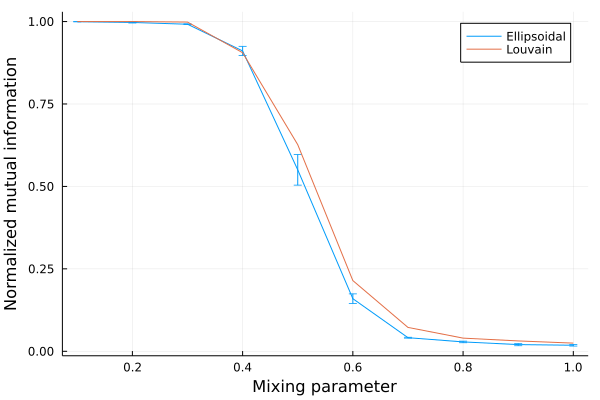

In [27]:
using StatsBase
using LaTeXStrings

pgfplotsx()
plot(mus, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Mixing parameter ",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")

plot!(mus, NMIs_louvain,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Louvain",
legend = (0.8,1))
savefig("figures/nmi_vs_mu.pdf")


gr()
# Plot Normalized mutual information vs Mixing parameter
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(mus, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Mixing parameter ",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")

plot!(mus, NMIs_louvain,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Louvain")
#savefig("figures/nmi_vs_mu.pdf")
plot!()



### Estimating the impact of $d_0$ on embedding quality

In [28]:
g = 4

# Set parameters of simulations
n_clusters = 100
d0s = 10:5:100

n_updates = 100 # max total by default
shape = "Ellipsoidal" #shape = "Spherical"

n_rep = 3
NMIs=zeros(Float64,length(d0s),n_rep)

# load communities
community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes = size(community_true)[1]
n_edges = size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj = adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true = community_true[vertices]
community_true = rename_com_unique(community_true)

# load parameters
LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
mu = parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(d0s)
    println("\n========== d0 step $i/$(length(d0s)) ==========")
    d0=d0s[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
        _,community,_ = @time sphere_embed_cluster(adj, d0,shape, n_clusters)

        NMIs[i,j] = mutualinfo(community_true,community)
    end
end


mu=0.4
========== d0 step 1/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 

193 iterations
  0.190743 seconds (5.12 k allocations: 135.373 MiB, 25.34% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10


Number of updates: 12
Modularity: 0.3695205441918179
Number of communities: 12
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22014787367182745, 0.2125061292954251, 0.18029156558600876, 0.12772715086311293, 0.0996265289995583]
 -------------------------------------------- 
  0.369350 seconds (201.75 k allocations: 253.360 MiB, 17.67% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 188 iterations
  0.174070 seconds (5.00 k allocations: 131.856 MiB, 17.21% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10
Number of updates: 

16
Modularity: 0.35967962305061374
Number of communities: 11
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21981484776502386, 0.21249350520882737, 0.18104270622470325, 0.12730728902528632, 0.09979694186385231]
 -------------------------------------------- 
  0.346469 seconds (226.37 k allocations: 264.306 MiB, 13.49% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 130 iterations
  0.113350 seconds (3.49 k allocations: 91.029 MiB, 13.73% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10
Number of updates: 

14
Modularity: 0.3678261206725555
Number of communities: 12
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21940750756340485, 0.21547024265868372, 0.18047770270209326, 0.13159295062506526, 0.09890930502673047]
 -------------------------------------------- 
  0.275887 seconds (181.57 k allocations: 199.184 MiB, 17.02% gc time)

========== d0 step 2/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 199 iterations
  0.260476 seconds (5.28 k allocations: 207.877 MiB, 10.17% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 15
Number of updates: 

6
Modularity: 0.38372516590713895
Number of communities: 17
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22018750807948645, 0.21276876444975246, 0.1808640401661459, 0.12803684491470022, 0.09913678832764738]
 -------------------------------------------- 
  0.368788 seconds (105.08 k allocations: 273.798 MiB, 10.89% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 215 iterations
  0.279071 seconds (5.70 k allocations: 224.651 MiB, 8.84% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 15
Number of updates: 

8
Modularity: 0.3840360890929356
Number of communities: 18
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2196740307959983, 0.21281557314267888, 0.18121925692694524, 0.12823251842022443, 0.09924424505260442]
 -------------------------------------------- 
  0.490050 seconds (122.02 k allocations: 301.127 MiB, 7.83% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 205 iterations
  0.287759 seconds (5.44 k allocations: 214.167 MiB, 14.54% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 15
Number of updates: 

6
Modularity: 0.38514967596548977
Number of communities: 18
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21988818471491128, 0.2129882061270366, 0.18131411933475364, 0.12806293787714398, 0.09911342447056859]
 -------------------------------------------- 
  0.414312 seconds (107.30 k allocations: 281.659 MiB, 13.74% gc time)

========== d0 step 3/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 146 iterations
  0.315649 seconds (3.91 k allocations: 202.356 MiB, 7.51% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 

4
Modularity: 0.3875700021290279
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22034588833323895, 0.21272367819230714, 0.1812057252271146, 0.12868184280563114, 0.09762665749258603]
 -------------------------------------------- 
  0.419652 seconds (80.99 k allocations: 256.302 MiB, 9.04% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 158 iterations
  0.273412 seconds (4.22 k allocations: 219.070 MiB, 8.58% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 

4
Modularity: 0.3872010483642303
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22036513176735087, 0.2130228475160889, 0.1808525914500832, 0.12801711343424474, 0.09869566449213718]
 -------------------------------------------- 
  0.408945 seconds (89.56 k allocations: 278.614 MiB, 9.38% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.275409 seconds (4.06 k allocations: 210.712 MiB, 9.07% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 4
Modularity: 0.38734707157584325
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2200134490656233, 0.21317910602046866, 0.1810103294917761, 0.12781659995304454, 0.09907799014714624]
 -------------------------------------------- 
  0.374649 seconds (81.09 k allocations: 264.758 MiB, 10.21% gc time)



========== d0 step 4/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 155 iterations
  0.343538 seconds (4.14 k allocations: 268.117 MiB, 10.46% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 25
Number of updates: 

7
Modularity: 0.38791423134763303
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21989058444119222, 0.2123669092988516, 0.18122776038246838, 0.12810876123248885, 0.09858219935449349]
 -------------------------------------------- 
  0.524227 seconds (108.14 k allocations: 342.990 MiB, 9.92% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 184 iterations
  0.422484 seconds (4.89 k allocations: 318.525 MiB, 11.78% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 25
Number of updates: 

3
Modularity: 0.38676221379415
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2194688177989181, 0.2128824348968621, 0.18062577858279516, 0.12779819528276654, 0.09924821512317135]
 -------------------------------------------- 
  0.540566 seconds (69.65 k allocations: 367.395 MiB, 9.20% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.376186 seconds (4.04 k allocations: 261.167 MiB, 10.80% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 25
Number of updates: 

5
Modularity: 0.38547204392009027
Number of communities: 19
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22026090370675372, 0.2126669420510234, 0.18125661815474187, 0.1285628476004981, 0.09841439939062709]
 -------------------------------------------- 
  0.537256 seconds (110.10 k allocations: 337.322 MiB, 10.13% gc time)

========== d0 step 5/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 180 iterations
  0.540840 seconds (4.79 k allocations: 373.482 MiB, 12.27% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.3881834425729131
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21988490193126276, 0.21280705728017618, 0.1803239945589401, 0.1278344835064416, 0.09944175031631554]
 -------------------------------------------- 
  0.860177 seconds (104.67 k allocations: 449.150 MiB, 7.72% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  0.411876 seconds (4.01 k allocations: 310.976 MiB, 11.74% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.3879742390543347
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22013922462496271, 0.21279412666429248, 0.1810582551197149, 0.12839530031398597, 0.09830792838020075]
 -------------------------------------------- 
  0.730784 seconds (105.97 k allocations: 388.118 MiB, 8.16% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 184 iterations
  0.486862 seconds (4.89 k allocations: 381.817 MiB, 9.18% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.38936520900133326
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21955444271131322, 0.21278925902814505, 0.18105419925481775, 0.12809324624457524, 0.09902021548995031]
 -------------------------------------------- 
  0.653763 seconds (98.60 k allocations: 453.285 MiB, 8.56% gc time)

========== d0 step 6/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.477094 seconds (4.06 k allocations: 367.444 MiB, 9.79% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 35
Number of updates: 

5
Modularity: 0.3880723639439155
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22030797475427977, 0.21274525177256584, 0.18097623236488744, 0.12846002932989692, 0.098532944923964]
 -------------------------------------------- 
  0.676499 seconds (106.06 k allocations: 447.163 MiB, 8.46% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.494429 seconds (4.04 k allocations: 365.014 MiB, 10.13% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 35
Number of updates: 

6
Modularity: 0.3878525976310465
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22002407840250746, 0.2126633381473837, 0.18104224766472443, 0.1288562382724126, 0.09848678335655345]
 -------------------------------------------- 
  0.793105 seconds (145.30 k allocations: 472.682 MiB, 9.91% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 118 iterations
  0.502517 seconds (3.18 k allocations: 284.844 MiB, 7.45% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 35
Number of updates: 

8
Modularity: 0.38848390328379506
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21982811654246867, 0.21262730773123706, 0.1813923320878485, 0.12786863469540757, 0.0997118576655436]
 -------------------------------------------- 
  0.816951 seconds (129.97 k allocations: 382.211 MiB, 6.60% gc time)

========== d0 step 7/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  0.615417 seconds (3.98 k allocations: 411.464 MiB, 10.37% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 40
Number of updates: 

5
Modularity: 0.38892540885725957
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22005721829692787, 0.21249637301025662, 0.18118751189688925, 0.1284463281434647, 0.09875373594889969]
 -------------------------------------------- 
  0.904748 seconds (114.27 k allocations: 500.289 MiB, 8.87% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 200 iterations
  0.801615 seconds (5.31 k allocations: 553.017 MiB, 8.39% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 40
Number of updates: 

6
Modularity: 0.38867132077790084
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21989914108974354, 0.21292236704032402, 0.1808240766982023, 0.1280852797436951, 0.09906731213794408]
 -------------------------------------------- 
  1.058201 seconds (107.34 k allocations: 635.982 MiB, 7.56% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.589754 seconds (4.04 k allocations: 417.015 MiB, 10.00% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 40
Number of updates: 

5
Modularity: 0.3873439616751895
Number of communities: 22
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2200373860204852, 0.21283013227470965, 0.18132268947321123, 0.1281868346856472, 0.09862716406513297]
 -------------------------------------------- 
  0.780902 seconds (93.66 k allocations: 490.952 MiB, 7.55% gc time)

========== d0 step 8/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.832369 seconds (4.06 k allocations: 472.213 MiB, 9.66% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 45
Number of updates: 

9
Modularity: 0.3877256643606781
Number of communities: 22
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2203272629722407, 0.21241276731078476, 0.18097207279341052, 0.12801041019882295, 0.09859149577787721]
 -------------------------------------------- 
  1.189217 seconds (128.81 k allocations: 575.759 MiB, 8.12% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.655818 seconds (4.04 k allocations: 469.091 MiB, 10.11% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 45
Number of updates: 

6
Modularity: 0.3883662119359341
Number of communities: 21
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21990925651248905, 0.2128447036599438, 0.18099519998404262, 0.1282692660551021, 0.09878432872756503]
 -------------------------------------------- 
  1.013989 seconds (132.92 k allocations: 575.783 MiB, 7.71% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 153 iterations
  0.672705 seconds (4.09 k allocations: 475.335 MiB, 11.60% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 45
Number of updates: 

8
Modularity: 0.3883009040222042
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22004054481598356, 0.21273189668581183, 0.18113450023452352, 0.12798769781364555, 0.0985338224718033]
 -------------------------------------------- 
  1.023190 seconds (130.91 k allocations: 580.989 MiB, 9.29% gc time)

========== d0 step 9/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 183 iterations
  0.862873 seconds (5.05 k allocations: 632.218 MiB, 9.48% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 50
Number of updates: 

8
Modularity: 0.387616721698393
Number of communities: 23
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21954230138566921, 0.21282206678792515, 0.18068217681907792, 0.12823170040487594, 0.0990382145868374]
 -------------------------------------------- 
  1.280611 seconds (142.22 k allocations: 750.482 MiB, 7.65% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 181 iterations
  0.908897 seconds (5.00 k allocations: 625.280 MiB, 9.82% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 50
Number of updates: 

7
Modularity: 0.3879585014522358
Number of communities: 23
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2197085922534992, 0.21285196551399818, 0.1807285702586181, 0.12820055982241713, 0.09901150760056245]
 -------------------------------------------- 
  1.267598 seconds (123.58 k allocations: 729.021 MiB, 8.21% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 148 iterations
  0.716526 seconds (4.11 k allocations: 510.799 MiB, 10.48% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 50
Number of updates: 

8
Modularity: 0.3876005828187904
Number of communities: 24
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22043820331194686, 0.21282376004972992, 0.18115662359582563, 0.1282338351178226, 0.09864403781112098]
 -------------------------------------------- 
  1.180383 seconds (137.15 k allocations: 625.710 MiB, 7.90% gc time)

========== d0 step 10/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 200 iterations
  1.259551 seconds (5.51 k allocations: 760.402 MiB, 7.54% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 55
Number of updates: 

8
Modularity: 0.3850044385889883
Number of communities: 26
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22016521026117014, 0.21295495240997572, 0.18099848278568426, 0.12803417171177506, 0.09916082078461372]
 -------------------------------------------- 
  1.723389 seconds (138.62 k allocations: 881.111 MiB, 6.13% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  0.777600 seconds (4.16 k allocations: 569.575 MiB, 8.91% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 55
Number of updates: 

8
Modularity: 0.38570117755468664
Number of communities: 28
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201115620452668, 0.212802279417519, 0.18104306621199764, 0.12838285975172212, 0.09835203977312236]
 -------------------------------------------- 
  1.244154 seconds (131.05 k allocations: 684.921 MiB, 8.63% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 153 iterations
  0.779221 seconds (4.24 k allocations: 581.024 MiB, 9.24% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 55
Number of updates: 

7
Modularity: 0.38797291400257766
Number of communities: 23
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201528892837539, 0.21270133472164446, 0.18131576668461796, 0.128410510886551, 0.0984398365669956]
 -------------------------------------------- 
  1.213638 seconds (133.21 k allocations: 697.854 MiB, 6.99% gc time)

========== d0 step 11/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.897598 seconds (4.21 k allocations: 629.786 MiB, 10.16% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 60
Number of updates: 

7
Modularity: 0.38615358450033543
Number of communities: 26
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2200639274087481, 0.21267775660850774, 0.18119014195011468, 0.12841024153667602, 0.09869423131780189]
 -------------------------------------------- 
  1.416016 seconds (129.08 k allocations: 746.510 MiB, 7.40% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.853860 seconds (4.21 k allocations: 629.785 MiB, 10.17% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 60
Number of updates: 

7
Modularity: 0.3852628822012519
Number of communities: 27
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22003084391562583, 0.21284589515491784, 0.18109511423333477, 0.12839079935205633, 0.09830794960478209]
 -------------------------------------------- 
  1.400747 seconds (133.22 k allocations: 750.435 MiB, 7.04% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.878598 seconds (4.21 k allocations: 629.785 MiB, 10.31% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 60
Number of updates: 

7
Modularity: 0.38439449260336467
Number of communities: 30
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2198904724681499, 0.21255064116146993, 0.18120994906477103, 0.12843008389567956, 0.09861947271001131]
 -------------------------------------------- 
  1.314650 seconds (118.75 k allocations: 737.774 MiB, 7.94% gc time)

========== d0 step 12/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  1.047801 seconds (4.13 k allocations: 668.901 MiB, 9.23% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 65
Number of updates: 

9
Modularity: 0.38606008266199543
Number of communities: 25
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22037199065686838, 0.21272702952383005, 0.18096436054051093, 0.12819994586702127, 0.0987287158238688]
 -------------------------------------------- 
  1.812237 seconds (157.95 k allocations: 815.309 MiB, 7.11% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  0.959769 seconds (4.13 k allocations: 668.901 MiB, 9.60% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 65
Number of updates: 

8
Modularity: 0.38438175204262165
Number of communities: 31
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22033315247311766, 0.21274819885379956, 0.1809502335363963, 0.12816911895520994, 0.09875432786387964]
 -------------------------------------------- 
  1.449832 seconds (124.93 k allocations: 786.569 MiB, 7.44% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  0.908514 seconds (4.16 k allocations: 673.413 MiB, 9.50% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 65
Number of updates: 

11
Modularity: 0.38580988613842787
Number of communities: 27
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22020381245847206, 0.2127116240642076, 0.18079273476825797, 0.12827358502762717, 0.0985689340879488]
 -------------------------------------------- 
  1.478662 seconds (137.31 k allocations: 801.646 MiB, 6.73% gc time)

========== d0 step 13/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  1.015478 seconds (4.16 k allocations: 725.415 MiB, 10.85% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 70
Number of updates: 

8
Modularity: 0.38330887811679865
Number of communities: 31
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22012635468523756, 0.21291476889428398, 0.18093576857547328, 0.12833345594109868, 0.0985501821128049]
 -------------------------------------------- 
  1.664498 seconds (131.23 k allocations: 853.699 MiB, 7.51% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  1.563527 seconds (4.16 k allocations: 725.415 MiB, 7.77% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 70
Number of updates: 

8
Modularity: 0.38546382191123807
Number of communities: 28
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22026471749728804, 0.21288365009417382, 0.18086273744393155, 0.12836601620893714, 0.09840385048270568]
 -------------------------------------------- 
  2.568741 seconds (137.37 k allocations: 858.258 MiB, 5.83% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  1.446212 seconds (4.21 k allocations: 735.138 MiB, 9.62% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 70
Number of updates: 

8
Modularity: 0.3855305008564391
Number of communities: 29
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22018512797482084, 0.212681923064852, 0.18089758462701724, 0.1283465046708307, 0.09867719885412563]
 -------------------------------------------- 
  2.176137 seconds (137.46 k allocations: 868.547 MiB, 7.35% gc time)

========== d0 step 14/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  1.343991 seconds (4.16 k allocations: 777.483 MiB, 9.50% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 75
Number of updates: 

8
Modularity: 0.38271357040011267
Number of communities: 31
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201314608052114, 0.21282147150886105, 0.1809302274147152, 0.1281805911717127, 0.09874125081417773]
 -------------------------------------------- 
  2.244111 seconds (151.91 k allocations: 930.040 MiB, 6.48% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  2.751863 seconds (4.18 k allocations: 782.693 MiB, 7.81% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 75
Number of updates: 

7
Modularity: 0.383105764820334
Number of communities: 29
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22012270105578546, 0.21279392962684446, 0.18114623456609433, 0.1284198296961219, 0.09846949887334856]
 -------------------------------------------- 
  4.161137 seconds (143.67 k allocations: 927.426 MiB, 6.79% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  3.136749 seconds (4.18 k allocations: 782.693 MiB, 10.15% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 75
Number of updates: 

9
Modularity: 0.38343676860121245
Number of communities: 30
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2200203584773573, 0.21269510786262566, 0.1809502930163796, 0.12815150867153477, 0.09887932083680276]
 -------------------------------------------- 
  6.863759 seconds (143.71 k allocations: 927.839 MiB, 6.29% gc time)

========== d0 step 15/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  5.037469 seconds (4.19 k allocations: 835.148 MiB, 6.47% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 80
Number of updates: 

9
Modularity: 0.3813084721410042
Number of communities: 31
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22012181575352296, 0.21270929361993182, 0.18099679596383914, 0.12844812603556546, 0.09842353370040499]
 -------------------------------------------- 
  7.462928 seconds (139.62 k allocations: 978.093 MiB, 5.45% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  1.733630 seconds (4.18 k allocations: 835.147 MiB, 7.59% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 80
Number of updates: 

10
Modularity: 0.384277804449263
Number of communities: 31
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22010695063221236, 0.2126144588017625, 0.18100912941203096, 0.12833468960169775, 0.0986879427486446]
 -------------------------------------------- 
  2.788399 seconds (156.14 k allocations: 993.751 MiB, 6.19% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  1.778582 seconds (4.21 k allocations: 840.706 MiB, 9.36% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 80
Number of updates: 

10
Modularity: 0.3838040503764113
Number of communities: 34
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2198467822801203, 0.21272325890075158, 0.18128156756443375, 0.1283637456756744, 0.09846756169013099]
 -------------------------------------------- 
  2.634025 seconds (162.39 k allocations: 1005.354 MiB, 7.10% gc time)

========== d0 step 16/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  1.558836 seconds (4.21 k allocations: 893.594 MiB, 10.65% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 85
Number of updates: 

7
Modularity: 0.37494942335962916
Number of communities: 38
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2202237427324588, 0.21256638577717507, 0.18120401086651142, 0.12816878654148223, 0.09847311956182651]
 -------------------------------------------- 
  2.232102 seconds (123.19 k allocations: 1.003 GiB, 8.09% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  1.318233 seconds (4.13 k allocations: 875.868 MiB, 10.24% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 85
Number of updates: 

8
Modularity: 0.3838949773507691
Number of communities: 30
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201654848121085, 0.21274669837763724, 0.1812662359916643, 0.12832212172441054, 0.09844020619779609]
 -------------------------------------------- 
  2.194436 seconds (154.17 k allocations: 1.017 GiB, 7.98% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  1.366462 seconds (4.13 k allocations: 875.867 MiB, 8.86% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 85
Number of updates: 

9
Modularity: 0.3757182376169587
Number of communities: 38
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22017474596768172, 0.21261562618885416, 0.18107549119048527, 0.12836227364009067, 0.09858080187383007]
 -------------------------------------------- 
  2.235889 seconds (152.06 k allocations: 1.014 GiB, 6.18% gc time)

========== d0 step 17/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  1.362693 seconds (4.18 k allocations: 940.258 MiB, 8.66% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 90
Number of updates: 

12
Modularity: 0.3794459885872164
Number of communities: 35
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22011583241601473, 0.2126761189591319, 0.1810557923861784, 0.1283406532310257, 0.09855331185601232]
 -------------------------------------------- 
  2.707045 seconds (187.34 k allocations: 1.114 GiB, 6.96% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  1.525259 seconds (4.16 k allocations: 933.999 MiB, 10.89% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 90
Number of updates: 

9
Modularity: 0.383797379137912
Number of communities: 36
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22028869768957854, 0.2127411164871542, 0.18095459387473178, 0.12817909966557545, 0.09849636883172998]
 -------------------------------------------- 
  2.441346 seconds (152.18 k allocations: 1.074 GiB, 8.39% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  1.430526 seconds (4.16 k allocations: 934.000 MiB, 9.80% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 90
Number of updates: 

10
Modularity: 0.3777341847360742
Number of communities: 38
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22025045955393788, 0.21285237411959776, 0.18103523425566423, 0.12840938195936055, 0.09839585269695524]
 -------------------------------------------- 
  2.533304 seconds (162.46 k allocations: 1.083 GiB, 6.73% gc time)

========== d0 step 18/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  2.526261 seconds (4.16 k allocations: 986.297 MiB, 6.56% gc time)


 -------------- Clustering ------- 
dimension of embedding used for clustering: 95
Number of updates: 

9
Modularity: 0.37492556406805405
Number of communities: 36
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22009613125132943, 0.21283644576061966,

 0.18105562046721932, 0.12836353538900255, 0.09865115715829671]
 -------------------------------------------- 
  5.660914 seconds (162.68 k allocations: 1.142 GiB, 4.08% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  5.513544 seconds (4.13 k allocations: 979.686 MiB, 10.91% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 95
Number of updates: 

9
Modularity: 0.3757231365464832
Number of communities: 39
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22002594075445542, 0.21260897960947947, 0.18116116911292848, 0.12826203070326894, 0.09867537350808751]
 -------------------------------------------- 
  7.427326 seconds (154.35 k allocations: 1.128 GiB, 9.08% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  1.989428 seconds (4.18 k allocations: 992.906 MiB, 9.53% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 95
Number of updates: 

10
Modularity: 0.3797080687768575
Number of communities: 37
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22014778594032083, 0.2128669001906023, 0.1809238239503157, 0.1281717668296396, 0.09855074706719577]
 -------------------------------------------- 
  3.733270 seconds (170.96 k allocations: 1.158 GiB, 7.50% gc time)

========== d0 step 19/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  2.366339 seconds (4.13 k allocations: 1.007 GiB, 7.29% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 

11
Modularity: 0.37529810425054116
Number of communities: 41
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201940724683534, 0.21279862578556108, 0.18087973508692762, 0.1284344936416348, 0.09854216622316059]
 -------------------------------------------- 
  4.206516 seconds (158.50 k allocations: 1.185 GiB, 5.51% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  2.297347 seconds (4.16 k allocations: 1.014 GiB, 7.98% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 

8
Modularity: 0.3769809617817537
Number of communities: 41
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201475461258616, 0.21270184255219235, 0.18092577332149679, 0.12837269860387107, 0.09850884272582947]
 -------------------------------------------- 
  4.144650 seconds (175.11 k allocations: 1.209 GiB, 5.57% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  2.206771 seconds (4.18 k allocations: 1.021 GiB, 7.76% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 

11
Modularity: 0.38118846926752287
Number of communities: 43
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22017253303057222, 0.21268136404289023, 0.18102099705931318, 0.12816511643381417, 0.09879700223366875]
 -------------------------------------------- 
  3.678585 seconds (177.25 k allocations: 1.217 GiB, 5.78% gc time)


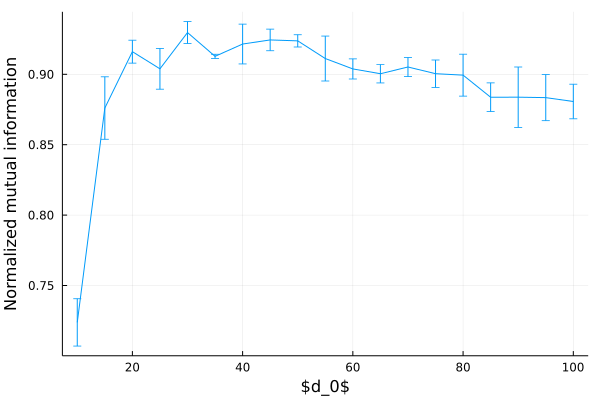

In [29]:
# Plot Normalized mutual information vs d0
m = mean(NMIs,dims=2)
s = std(NMIs,dims=2)


pgfplotsx()
plot(d0s, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"$d_0$",
ylabel = "Normalized mutual information",
legend = false)
savefig("figures/nmi_vs_d0__mu"*string(mu)*".pdf")

gr()
plot(d0s, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"$d_0$",
ylabel = "Normalized mutual information",
legend = false)

plot!()


### Test impact of n_clusters

In [30]:
g = 4

# Set parameters of simulations
n_clusters_list = 10:10:100
d0 = 30;
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(n_clusters_list),n_rep)

# load communities
community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes = size(community_true)[1]
n_edges = size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj = adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true = community_true[vertices]
community_true = rename_com_unique(community_true)

# load parameters
LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
mu = parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(n_clusters_list)
    println("\n========== n_clusters step $i/$(length(n_clusters_list)) ==========")
    n_clusters = n_clusters_list[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")

        # embed cluster
        _,community,_ = @time sphere_embed_cluster(adj, d0,shape, n_clusters)

        NMIs[i,j] = mutualinfo(community_true,community);
    end
end




mu=0.4
========== n_clusters step 1/10 ==========



  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 

152 iterations
  0.573471 seconds (4.06 k allocations: 315.141 MiB, 15.71% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 10
Modularity: 0.3656597362892861
Number of communities: 9
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22009467848939568, 0.21258238732964285, 0.18103177004102297, 0.1283557983843239, 0.0986522631363717]
 -------------------------------------------- 
  0.662758 seconds (154.49 k allocations: 362.192 MiB, 13.60% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 154 iterations
  0.555987 seconds (4.11 k allocations: 319.310 MiB, 10.26% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

13
Modularity: 0.3609394504934288
Number of communities: 8
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2196109099613078, 0.2125357971738493, 0.18112674841902304, 0.1285164943850295, 0.09871811932768128]
 -------------------------------------------- 
  0.659531 seconds (183.26 k allocations: 374.741 MiB, 11.68% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.503566 seconds (4.06 k allocations: 315.143 MiB, 10.93% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 9
Modularity: 0.3592789474631525
Number of communities: 9
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22021202544769064, 0.21230968395021677, 0.18075643024057583, 0.12844357128690453, 0.09839128271303137]
 -------------------------------------------- 
  0.593540 seconds (152.44 k allocations: 361.574 MiB, 9.27% gc time)

========== n_clusters step 2/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 145 iterations
  0.463050 seconds (3.88 k allocations: 300.559 MiB, 10.85% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

10
Modularity: 0.3822785855860837
Number of communities: 14
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22064452084810618, 0.2128228250136931, 0.18128150773339588, 0.1285737050474461, 0.09739832276806437]
 -------------------------------------------- 
  0.662547 seconds (198.35 k allocations: 371.974 MiB, 7.58% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 184 iterations
  0.593888 seconds (4.89 k allocations: 381.816 MiB, 12.16% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

11
Modularity: 0.37656449843250556
Number of communities: 14
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21969317862191629, 0.21277081817226545, 0.18097378907509976, 0.12810830171385976, 0.09915018870884663]
 -------------------------------------------- 
  0.699146 seconds (166.37 k allocations: 441.374 MiB, 10.33% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 156 iterations
  0.486192 seconds (4.17 k allocations: 323.478 MiB, 10.55% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

8
Modularity: 0.36759500991025856
Number of communities: 11
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21980649081893658, 0.21253934110091358, 0.18077465982361046, 0.12851828315297234, 0.09874320890926801]
 -------------------------------------------- 
  0.597671 seconds (153.19 k allocations: 377.985 MiB, 11.95% gc time)

========== n_clusters step 3/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 210 iterations
  0.658447 seconds (5.57 k allocations: 435.989 MiB, 9.79% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 5
Modularity: 0.3791644088188791
Number of communities: 16
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2199960876221196, 0.21286250117517966, 0.1809300306619184, 0.12787621401719582, 0.0991398530076384]
 -------------------------------------------- 
  0.739809 seconds (107.22 k allocations: 480.435 MiB, 8.71% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 154 iterations
  0.477943 seconds (4.11 k allocations: 319.311 MiB, 10.39% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.3844350341711621
Number of communities: 17
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22003887460412772, 0.2127594474733732, 0.18066415597703547, 0.12864330067849983, 0.09823793099880829]
 -------------------------------------------- 
  0.583843 seconds (132.67 k allocations: 375.027 MiB, 8.51% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 156 iterations
  0.495375 seconds (4.17 k allocations: 323.477 MiB, 10.70% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.37732078112779194
Number of communities: 16
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22023723466497164, 0.2130222536569637, 0.1809604381752729, 0.12813128296114573, 0.09796808183123339]
 -------------------------------------------- 
  0.606871 seconds (118.25 k allocations: 373.050 MiB, 11.81% gc time)

========== n_clusters step 4/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 153 iterations
  0.453198 seconds (4.09 k allocations: 317.228 MiB, 6.88% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.38538297285418716
Number of communities: 18
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22010327564615198, 0.21262797536848332, 0.18042189387206875, 0.12821262485998364, 0.09908513764353612]
 -------------------------------------------- 
  0.731845 seconds (153.31 k allocations: 386.870 MiB, 6.66% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 156 iterations
  0.495322 seconds (4.17 k allocations: 323.477 MiB, 10.27% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

9
Modularity: 0.3830777339147098
Number of communities: 17
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2197269318158872, 0.21276718646154746, 0.1809075694502233, 0.1278999311808713, 0.099399778201648]
 -------------------------------------------- 
  0.625275 seconds (126.55 k allocations: 380.978 MiB, 8.14% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 154 iterations
  0.507584 seconds (4.11 k allocations: 319.310 MiB, 10.17% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.3818081713124556
Number of communities: 17
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21976612051104757, 0.21238279411970254, 0.18170222418541968, 0.12929203314967638, 0.09760516708191978]
 -------------------------------------------- 
  0.644551 seconds (126.50 k allocations: 377.141 MiB, 10.81% gc time)

========== n_clusters step 5/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  0.520804 seconds (4.01 k allocations: 310.976 MiB, 5.67% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

7
Modularity: 0.3821474221820302
Number of communities: 18
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2203994194395416, 0.2127423776401104, 0.18079728653426821, 0.12874475600020763, 0.09827775736141998]
 -------------------------------------------- 
  0.689317 seconds (118.25 k allocations: 371.315 MiB, 7.45% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 182 iterations
  0.557225 seconds (4.84 k allocations: 377.649 MiB, 8.69% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

9
Modularity: 0.3874980605965648
Number of communities: 19
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.219487733364772, 0.21293556686958565, 0.1809574333455891, 0.12800171215911182, 0.09923543518352633]
 -------------------------------------------- 
  0.716243 seconds (119.09 k allocations: 438.241 MiB, 9.73% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 187 iterations
  0.585033 seconds (4.97 k allocations: 388.067 MiB, 8.50% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

7
Modularity: 0.3844305532390372
Number of communities: 18
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21959945583508295, 0.21249945269666204, 0.1809245224857576, 0.1279069119310166, 0.09954515090313996]
 -------------------------------------------- 
  0.728665 seconds (119.20 k allocations: 448.384 MiB, 9.29% gc time)

========== n_clusters step 6/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.482814 seconds (4.06 k allocations: 315.143 MiB, 9.79% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.3869614815145373
Number of communities: 19
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21995134015287787, 0.21273448715478122, 0.18084285219506208, 0.12808342160142858, 0.09899111791547849]
 -------------------------------------------- 
  0.617554 seconds (105.92 k allocations: 374.348 MiB, 7.65% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  0.479345 seconds (4.01 k allocations: 310.976 MiB, 11.18% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.3871140296655597
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2199353778498636, 0.21284323769323035, 0.18121406912640492, 0.12901373280055478, 0.0981379546469408]
 -------------------------------------------- 
  0.637004 seconds (124.45 k allocations: 380.001 MiB, 8.41% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 153 iterations
  0.484916 seconds (4.09 k allocations: 317.227 MiB, 11.36% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.3880855266820322
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21990624801112163, 0.21291645385010743, 0.18124776570722617, 0.12844081891288053, 0.09817955729307726]
 -------------------------------------------- 
  0.635796 seconds (105.95 k allocations: 376.348 MiB, 11.80% gc time)

========== n_clusters step 7/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 148 iterations
  0.459867 seconds (3.96 k allocations: 306.809 MiB, 6.92% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.38784080592440096
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22022514613757196, 0.21233334622089972, 0.18097407829030696, 0.12812997679110766, 0.09865563836407419]
 -------------------------------------------- 
  0.604405 seconds (93.50 k allocations: 363.996 MiB, 8.15% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.471010 seconds (4.04 k allocations: 313.059 MiB, 10.38% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.38752517608788356
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2199598569742497, 0.21219950601855112, 0.18080590718945974, 0.12816508143467598, 0.09911461654752851]
 -------------------------------------------- 
  0.620771 seconds (112.18 k allocations: 381.079 MiB, 7.87% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 147 iterations
  0.451083 seconds (3.93 k allocations: 304.726 MiB, 11.42% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.3880639496562594
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22001023763237215, 0.21304959924577815, 0.18134132454025795, 0.12862468482435602, 0.09828341426135559]
 -------------------------------------------- 
  0.607153 seconds (114.16 k allocations: 374.170 MiB, 8.48% gc time)

========== n_clusters step 8/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 154 iterations
  0.483609 seconds (4.11 k allocations: 319.310 MiB, 11.44% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

7
Modularity: 0.3882118329563011
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22025511768996048, 0.2128413278465828, 0.18056140958732897, 0.1284140022410287, 0.09838038981042545]
 -------------------------------------------- 
  0.664568 seconds (110.20 k allocations: 390.054 MiB, 11.07% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.454375 seconds (4.04 k allocations: 313.059 MiB, 7.51% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.3887993575614045
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22004012177086055, 0.21283743166394745, 0.18103611885849752, 0.12896514620413374, 0.09788760092135997]
 -------------------------------------------- 
  0.629768 seconds (103.93 k allocations: 380.193 MiB, 8.04% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  0.474416 seconds (3.98 k allocations: 308.892 MiB, 11.44% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.388420271539638
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22025682715232586, 0.2131112515233406, 0.18090378146925365, 0.12824685911370684, 0.09825268928078357]
 -------------------------------------------- 
  0.627988 seconds (99.74 k allocations: 373.299 MiB, 8.65% gc time)

========== n_clusters step 9/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 110 iterations
  0.334590 seconds (2.97 k allocations: 227.634 MiB, 11.44% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.38683710638825514
Number of communities: 19
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21921608549583604, 0.2126236115683194, 0.1811859810864068, 0.1280565742283301, 0.10022015302834529]
 -------------------------------------------- 
  0.521903 seconds (100.80 k allocations: 297.406 MiB, 10.94% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.477971 seconds (4.06 k allocations: 315.143 MiB, 10.43% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.38762185888643536
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22006106702158942, 0.21285993149496135, 0.18123583689772968, 0.1280646740682753, 0.09882144868676712]
 -------------------------------------------- 
  0.638704 seconds (99.83 k allocations: 384.000 MiB, 7.81% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 153 iterations
  0.474945 seconds (4.09 k allocations: 317.227 MiB, 11.41% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.3884303703568149
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22041148734021443, 0.21265414182218328, 0.18078123428504111, 0.12830079837276845, 0.09850561563448297]
 -------------------------------------------- 
  0.694014 seconds (122.57 k allocations: 400.525 MiB, 10.95% gc time)

========== n_clusters step 10/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 198 iterations
  0.604160 seconds (5.26 k allocations: 410.986 MiB, 8.90% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

4
Modularity: 0.38851048791841636
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21997932427649322, 0.2128134511817817, 0.1810529298998607, 0.12793006156373393, 0.09931495396588103]
 -------------------------------------------- 
  0.784359 seconds (82.45 k allocations: 471.104 MiB, 9.01% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 212 iterations
  0.652773 seconds (5.62 k allocations: 440.156 MiB, 7.33% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.38828473170280964
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22027859058330201, 0.21284384047965785, 0.18105459088602496, 0.1281098241580651, 0.09906575558959652]
 -------------------------------------------- 
  0.848226 seconds (105.52 k allocations: 515.607 MiB, 7.70% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 119 iterations
  0.368788 seconds (3.20 k allocations: 246.386 MiB, 10.19% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.388022099756601
Number of communities: 19
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2196169521668317, 0.21317837721419483, 0.1811869052343557, 0.12832643756378245, 0.09903984748934398]
 -------------------------------------------- 
  0.574203 seconds (101.05 k allocations: 320.724 MiB, 9.74% gc time)


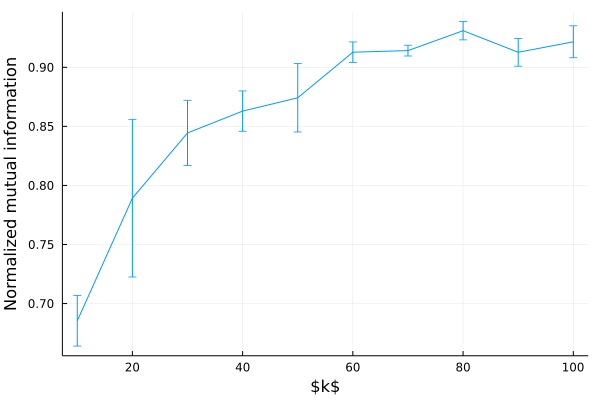

In [35]:
# Plot Normalized mutual information vs d0
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);

pgfplotsx()
plot(n_clusters_list, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"$k$",
ylabel = "Normalized mutual information",
legend = false)
savefig("figures/nmi_vs_nclusters__mu"*string(mu)*".pdf")


gr()
plot(n_clusters_list, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"k",
ylabel = "Normalized mutual information",
legend = false)
plot!()